# 深度学习模型
特征：
1. 滑动窗口采样
设置windows size，采样前k个step预测下一个

2. 滑动窗口平均采样

模型：
1. MLP
2. CNN
3. LSTM
4. RCNN
5. RWKV

todo：
1. 加入额外特征embedding

In [1]:
import pandas as pd
import numpy as np
import random
import pickle
import math
import os
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
from dataclasses import dataclass

# 1 读取处理后数据

字典数据：
```
{
    'tid':[
        [cycle_count],
        [battery_life]
    ]
}
```

DataFrame数据：
```
columns = [tid,cycle_count,life]
```

In [3]:
bmap = pickle.load(open("../data/processed/nasa-li-battery_dict_240906.pkl",'rb'))

In [4]:
ddf = pd.read_pickle('../data/processed/nasa-li-battery_df_240906.pkl')

# 2 特征采样和评价指标

## 2.1 特征采样

In [5]:
window_size = 10

In [6]:
def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)
        
    return np.array(x), np.array(y)


# 留一评估：一组数据为测试集，其他所有数据全部拿来训练
def get_train_test(data_dict, name, window_size=8, train_ratio=0.):
    data_sequence=data_dict[name][1]
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v[1], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)


def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse
    

def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re

## 2.2 训练和评价

In [7]:
from tqdm import tqdm

### 训练器

In [8]:
def regressor_trainer(skmodel,
                      data_dict,
                      window_size=10,
                      epoch=1000,
                      eval_step=10,
                    on_test_log=False):
    mae_lst,rmse_lst = [], []
    for i in tqdm(range(epoch)):
        if i%eval_step==0 and on_test_log:
            print('---------------------------------------------------')
        for name in data_dict.keys():
            train_x, train_y, train_data, test_data = get_train_test(data_dict, name, window_size)
            real_train_y = train_y[:,-1]
            
            test_x = train_data.copy()
        
            # (batch, window_size)-->(batch, 1)
            skmodel.fit(train_x,real_train_y)
    
            # Eval on every eval_step
            if (i+1)%eval_step==0:
                test_x = train_data.copy()
                point_list = []
                while (len(test_x) - len(train_data)) < len(test_data):
                    online_x = np.reshape(np.array(test_x[-window_size:]), (-1, window_size)).astype(np.float32)
            
                    next_point = skmodel.predict(online_x)[0]
                    
                    test_x.append(next_point)#测试值加入原来序列用来继续预测下一个点
                    point_list.append(next_point)#保存输出序列最后一个点的预测值
                
                mae, rmse = evaluation(y_test=test_data, y_predict=point_list)

                mae_lst.append(mae)
                rmse_lst.append(rmse)

                if on_test_log:
                    print(f'Epoch:{i} {name} MAE:{mae:.4f} | RMSE:{rmse:<6.4f}')
    print(f'Model:{skmodel.__str__()}')
    print(f'MAE:{np.average(mae_lst):.4f} RMSE:{np.average(rmse_lst):.4f}')
    return skmodel

### 预测绘图

### 绘图函数

In [9]:
def plot(name,
         real_data, 
         pred_data):
    fig, ax = plt.subplots(1, figsize=(12, 8))

    plot_range = [i for i in range(len(real_data))]
    
    ax.plot(plot_range, real_data, 'b.', label=name)
    ax.plot(plot_range, pred_data, 'r.', label='Prediction')
    plt.plot([-1,170],[2*0.7, 2*0.7], c='black', lw=1, ls='--')  # 临界点直线
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
    plt.legend()

# 3 MLP

MAELoss

In [10]:
from typing import List,Dict,Tuple

In [11]:
from collections import OrderedDict

In [12]:
import torch

In [13]:
class NASALiBatteryDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 fpath:str,
                ):
        
        x_lst,y_lst = [],[]
        self.data_dict = pickle.load(open(fpath,'rb'))
        for name in self.data_dict.keys():
            train_x, train_y, train_data, test_data = get_train_test(self.data_dict, name, window_size)
            real_train_y = np.expand_dims(train_y[:,-1],-1)
            x_lst.append(train_x)
            y_lst.append(real_train_y)
        self.train_x = np.vstack(x_lst)
        self.train_y = np.vstack(y_lst)
        
    def __len__(self):
        return self.train_x.shape[0]
        
    def __getitem__(self, indices):
        
        return np.take(self.train_x,axis=0,indices=indices), np.take(self.train_y,axis=0,indices=indices)

In [14]:
class BaseModel(torch.nn.Module):

    def __init__(self, 
                 prefix_length:int=1,
                 device:str='cpu'):
        super(BaseModel, self).__init__()
        
        self.prefix_length = prefix_length
        self.device = device
    def __post_init__(self):
        self.double()
        
    def decode(self,
               input_x:np.array,
               max_length:int):
        '''
        input_x: List(prefix_length, )
        max_length: target decode length
        '''
        if not self.prefix_length != len(input_x):
            assert(f'Error input sequence must be prefix_length shape:{self.prefix_length}')

        test_x = input_x
        
        # decode to target length
        for i in range(max_length+1):
            online_x = np.array(test_x[-self.prefix_length:])
            online_x = torch.tensor(online_x).double().to(self.device)
            test_x += self.forward(online_x).detach().numpy().tolist() #测试值加入原来序列用来继续预测下一个点

        # list
        return test_x
        
    def forward(self, 
                x:torch.Tensor):
        '''
        x: (prefix_length, )
        '''
        pass

In [15]:
class MLPModel(BaseModel):

    def __init__(self,
                 hidden_features:List[int],
                 prefix_length:int=1,
                 device:str='cpu'):
        super(MLPModel, self).__init__(
            prefix_length=prefix_length,
               device=device
        )

        hidden_features = [prefix_length] + hidden_features
        
        self.HiddenLayers = torch.nn.Sequential(
            OrderedDict(
                [
                    (f'linear{idx}',torch.nn.Linear(hidden_features[idx-1],hidden_features[idx])) for idx in range(1,len(hidden_features))
                ]
            )
        )
        
        self.OutputLinear = torch.nn.Linear(in_features=hidden_features[-1],
                                            out_features=1,
                                            bias=False)
        self.__post_init__()
    def forward(self,
                x:torch.Tensor):
        x = self.HiddenLayers(x)
        y = self.OutputLinear(x)
        return y

In [16]:
window_size = 8
epoch = 10000
learning_rate = 0.01    # learning rate
weight_decay = 0.0
hidden_size = [8]
batch_size = 64

In [17]:
data_dict = bmap

In [18]:
model = MLPModel(hidden_features=hidden_size,
                 prefix_length=window_size)

In [19]:
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=weight_decay)
criterion = torch.nn.MSELoss()

In [20]:
eval_step = 100

In [21]:
on_test_log = True

In [22]:
train_dataset = NASALiBatteryDataset(fpath='../data/processed/nasa-li-battery_dict_240906.pkl')

In [23]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)

In [24]:
loss_list = [0]
mae_lst,rmse_lst = [], []

for i in tqdm(range(epoch)):
    if i%eval_step==0 and on_test_log:
        print('---------------------------------------------------')
    for batch_x,batch_y in train_loader:
        output= model(batch_x)
        loss = criterion(output, batch_y)
        optimizer.zero_grad()              # clear gradients for this training step
        loss.backward()                    # backpropagation, compute gradients
        optimizer.step()                   # apply gradients

        loss_list.append(loss.detach().numpy().tolist())

    if i%eval_step==0:
        for name in data_dict.keys():
            train_x, train_y, train_data, test_data = get_train_test(data_dict, name, window_size)
            
            prefix_x = data_dict[name][1][:window_size]
            decode_seq = model.decode(prefix_x,max_length=len(test_data))[window_size+1:]
            mae, rmse = evaluation(y_test=test_data, y_predict=decode_seq)
            
            mae_lst.append(mae)
            rmse_lst.append(rmse)
        
        if on_test_log:
            print(f'Epoch:{i} Loss:{np.average(loss_list):.4f} MAE:{np.average(mae_lst):.4f} | RMSE:{np.average(rmse_lst):<6.4f}')

  0%|                                                                          | 1/10000 [00:00<27:58,  5.96it/s]

---------------------------------------------------
Epoch:0 Loss:0.7263 MAE:1.1940 | RMSE:1.2085


  1%|▋                                                                       | 101/10000 [00:05<09:51, 16.73it/s]

---------------------------------------------------
Epoch:100 Loss:0.0082 MAE:0.6353 | RMSE:0.6457


  2%|█▍                                                                      | 203/10000 [00:10<08:59, 18.15it/s]

---------------------------------------------------
Epoch:200 Loss:0.0044 MAE:0.4824 | RMSE:0.4980


  3%|██▏                                                                     | 302/10000 [00:15<08:12, 19.68it/s]

---------------------------------------------------
Epoch:300 Loss:0.0031 MAE:0.4424 | RMSE:0.4602


  4%|██▉                                                                     | 402/10000 [00:20<08:31, 18.77it/s]

---------------------------------------------------
Epoch:400 Loss:0.0024 MAE:0.3720 | RMSE:0.3886


  5%|███▌                                                                    | 501/10000 [00:24<07:57, 19.88it/s]

---------------------------------------------------
Epoch:500 Loss:0.0020 MAE:0.3265 | RMSE:0.3424


  6%|████▎                                                                   | 600/10000 [00:29<07:45, 20.21it/s]

---------------------------------------------------
Epoch:600 Loss:0.0018 MAE:0.2941 | RMSE:0.3092


  7%|█████                                                                   | 703/10000 [00:34<08:05, 19.14it/s]

---------------------------------------------------
Epoch:700 Loss:0.0016 MAE:0.2857 | RMSE:0.3032


  8%|█████▊                                                                  | 801/10000 [00:39<11:53, 12.89it/s]

---------------------------------------------------
Epoch:800 Loss:0.0014 MAE:0.2618 | RMSE:0.2782


  9%|██████▍                                                                 | 901/10000 [00:44<08:17, 18.28it/s]

---------------------------------------------------
Epoch:900 Loss:0.0013 MAE:0.2488 | RMSE:0.2645


 10%|███████                                                                | 1003/10000 [00:49<07:52, 19.06it/s]

---------------------------------------------------
Epoch:1000 Loss:0.0012 MAE:0.2370 | RMSE:0.2522


 11%|███████▊                                                               | 1101/10000 [00:53<08:25, 17.59it/s]

---------------------------------------------------
Epoch:1100 Loss:0.0011 MAE:0.2235 | RMSE:0.2382


 12%|████████▌                                                              | 1201/10000 [00:58<07:59, 18.34it/s]

---------------------------------------------------
Epoch:1200 Loss:0.0011 MAE:0.2117 | RMSE:0.2259


 13%|█████████▏                                                             | 1302/10000 [01:03<07:41, 18.84it/s]

---------------------------------------------------
Epoch:1300 Loss:0.0010 MAE:0.2124 | RMSE:0.2267


 14%|█████████▉                                                             | 1400/10000 [01:08<06:48, 21.05it/s]

---------------------------------------------------
Epoch:1400 Loss:0.0010 MAE:0.2156 | RMSE:0.2303


 15%|██████████▋                                                            | 1501/10000 [01:13<07:31, 18.82it/s]

---------------------------------------------------
Epoch:1500 Loss:0.0009 MAE:0.2318 | RMSE:0.2498


 16%|███████████▎                                                           | 1600/10000 [01:17<06:24, 21.85it/s]

---------------------------------------------------
Epoch:1600 Loss:0.0009 MAE:0.2225 | RMSE:0.2400


 17%|████████████                                                           | 1701/10000 [01:22<07:28, 18.50it/s]

---------------------------------------------------
Epoch:1700 Loss:0.0009 MAE:0.2296 | RMSE:0.2489


 18%|████████████▊                                                          | 1799/10000 [01:29<13:58,  9.78it/s]

---------------------------------------------------


 18%|████████████▊                                                          | 1802/10000 [01:30<18:45,  7.28it/s]

Epoch:1800 Loss:0.0008 MAE:0.2381 | RMSE:0.2579


 19%|█████████████▍                                                         | 1899/10000 [01:40<13:03, 10.35it/s]

---------------------------------------------------


 19%|█████████████▌                                                         | 1903/10000 [01:40<15:05,  8.95it/s]

Epoch:1900 Loss:0.0008 MAE:0.2307 | RMSE:0.2499


 20%|██████████████▏                                                        | 1999/10000 [01:50<13:24,  9.95it/s]

---------------------------------------------------


 20%|██████████████▏                                                        | 2003/10000 [01:51<14:57,  8.91it/s]

Epoch:2000 Loss:0.0008 MAE:0.2303 | RMSE:0.2502


 21%|██████████████▉                                                        | 2099/10000 [01:58<10:52, 12.11it/s]

---------------------------------------------------


 21%|██████████████▉                                                        | 2103/10000 [01:59<12:47, 10.29it/s]

Epoch:2100 Loss:0.0008 MAE:0.2258 | RMSE:0.2453


 22%|███████████████▌                                                       | 2200/10000 [02:07<12:33, 10.35it/s]

---------------------------------------------------


 22%|███████████████▋                                                       | 2202/10000 [02:08<16:02,  8.10it/s]

Epoch:2200 Loss:0.0007 MAE:0.2383 | RMSE:0.2602


 23%|████████████████▎                                                      | 2301/10000 [02:16<12:14, 10.48it/s]

---------------------------------------------------
Epoch:2300 Loss:0.0007 MAE:0.2443 | RMSE:0.2675


 24%|█████████████████                                                      | 2401/10000 [02:25<12:02, 10.52it/s]

---------------------------------------------------
Epoch:2400 Loss:0.0007 MAE:0.2372 | RMSE:0.2599


 25%|█████████████████▋                                                     | 2499/10000 [02:33<11:49, 10.57it/s]

---------------------------------------------------


 25%|█████████████████▊                                                     | 2503/10000 [02:33<13:16,  9.41it/s]

Epoch:2500 Loss:0.0007 MAE:0.2327 | RMSE:0.2552


 26%|██████████████████▍                                                    | 2600/10000 [02:41<09:19, 13.23it/s]

---------------------------------------------------
Epoch:2600 Loss:0.0007 MAE:0.2302 | RMSE:0.2523


 27%|███████████████████▏                                                   | 2700/10000 [02:49<09:03, 13.42it/s]

---------------------------------------------------


 27%|███████████████████▏                                                   | 2702/10000 [02:50<11:47, 10.31it/s]

Epoch:2700 Loss:0.0007 MAE:0.2385 | RMSE:0.2623


 28%|███████████████████▉                                                   | 2800/10000 [02:57<09:08, 13.12it/s]

---------------------------------------------------
Epoch:2800 Loss:0.0007 MAE:0.2354 | RMSE:0.2587


 29%|████████████████████▌                                                  | 2900/10000 [03:05<09:13, 12.82it/s]

---------------------------------------------------


 29%|████████████████████▌                                                  | 2902/10000 [03:06<12:12,  9.69it/s]

Epoch:2900 Loss:0.0007 MAE:0.2300 | RMSE:0.2528


 30%|█████████████████████▎                                                 | 3001/10000 [03:16<11:42,  9.96it/s]

---------------------------------------------------
Epoch:3000 Loss:0.0006 MAE:0.2248 | RMSE:0.2471


 31%|██████████████████████                                                 | 3101/10000 [03:24<11:46,  9.76it/s]

---------------------------------------------------
Epoch:3100 Loss:0.0006 MAE:0.2269 | RMSE:0.2492


 32%|██████████████████████▋                                                | 3201/10000 [03:33<11:35,  9.77it/s]

---------------------------------------------------
Epoch:3200 Loss:0.0006 MAE:0.2276 | RMSE:0.2503


 33%|███████████████████████▍                                               | 3299/10000 [03:42<10:04, 11.09it/s]

---------------------------------------------------


 33%|███████████████████████▍                                               | 3303/10000 [03:42<12:02,  9.27it/s]

Epoch:3300 Loss:0.0006 MAE:0.2250 | RMSE:0.2477


 34%|████████████████████████▏                                              | 3400/10000 [03:52<09:20, 11.78it/s]

---------------------------------------------------


 34%|████████████████████████▏                                              | 3402/10000 [03:52<11:47,  9.33it/s]

Epoch:3400 Loss:0.0006 MAE:0.2321 | RMSE:0.2551


 35%|████████████████████████▊                                              | 3501/10000 [04:01<11:11,  9.68it/s]

---------------------------------------------------
Epoch:3500 Loss:0.0006 MAE:0.2340 | RMSE:0.2575


 36%|█████████████████████████▌                                             | 3599/10000 [04:09<09:05, 11.73it/s]

---------------------------------------------------


 36%|█████████████████████████▌                                             | 3603/10000 [04:10<10:58,  9.71it/s]

Epoch:3600 Loss:0.0006 MAE:0.2310 | RMSE:0.2542


 37%|██████████████████████████▎                                            | 3700/10000 [04:20<11:44,  8.94it/s]

---------------------------------------------------


 37%|██████████████████████████▎                                            | 3702/10000 [04:20<15:17,  6.86it/s]

Epoch:3700 Loss:0.0006 MAE:0.2284 | RMSE:0.2514


 38%|██████████████████████████▉                                            | 3800/10000 [04:30<08:35, 12.04it/s]

---------------------------------------------------


 38%|██████████████████████████▉                                            | 3802/10000 [04:30<10:43,  9.63it/s]

Epoch:3800 Loss:0.0006 MAE:0.2246 | RMSE:0.2472


 39%|███████████████████████████▋                                           | 3899/10000 [04:39<09:03, 11.23it/s]

---------------------------------------------------


 39%|███████████████████████████▋                                           | 3903/10000 [04:39<10:17,  9.87it/s]

Epoch:3900 Loss:0.0006 MAE:0.2227 | RMSE:0.2453


 40%|████████████████████████████▍                                          | 3999/10000 [04:47<08:49, 11.33it/s]

---------------------------------------------------


 40%|████████████████████████████▍                                          | 4003/10000 [04:48<10:21,  9.65it/s]

Epoch:4000 Loss:0.0006 MAE:0.2297 | RMSE:0.2526


 41%|█████████████████████████████                                          | 4099/10000 [04:57<08:48, 11.17it/s]

---------------------------------------------------


 41%|█████████████████████████████▏                                         | 4103/10000 [04:57<09:51,  9.98it/s]

Epoch:4100 Loss:0.0006 MAE:0.2303 | RMSE:0.2531


 42%|█████████████████████████████▊                                         | 4199/10000 [05:06<08:22, 11.54it/s]

---------------------------------------------------


 42%|█████████████████████████████▊                                         | 4203/10000 [05:06<09:58,  9.68it/s]

Epoch:4200 Loss:0.0006 MAE:0.2268 | RMSE:0.2492


 43%|██████████████████████████████▌                                        | 4299/10000 [05:15<08:53, 10.68it/s]

---------------------------------------------------


 43%|██████████████████████████████▌                                        | 4303/10000 [05:16<10:06,  9.40it/s]

Epoch:4300 Loss:0.0006 MAE:0.2243 | RMSE:0.2465


 44%|███████████████████████████████▏                                       | 4399/10000 [05:24<08:00, 11.66it/s]

---------------------------------------------------


 44%|███████████████████████████████▎                                       | 4403/10000 [05:25<09:30,  9.82it/s]

Epoch:4400 Loss:0.0006 MAE:0.2209 | RMSE:0.2428


 45%|███████████████████████████████▉                                       | 4499/10000 [05:33<07:47, 11.77it/s]

---------------------------------------------------


 45%|███████████████████████████████▉                                       | 4503/10000 [05:34<08:57, 10.23it/s]

Epoch:4500 Loss:0.0006 MAE:0.2364 | RMSE:0.2610


 46%|████████████████████████████████▋                                      | 4599/10000 [05:43<08:37, 10.44it/s]

---------------------------------------------------


 46%|████████████████████████████████▋                                      | 4603/10000 [05:43<09:31,  9.44it/s]

Epoch:4600 Loss:0.0006 MAE:0.2329 | RMSE:0.2571


 47%|█████████████████████████████████▎                                     | 4699/10000 [05:52<08:42, 10.15it/s]

---------------------------------------------------


 47%|█████████████████████████████████▍                                     | 4703/10000 [05:52<09:55,  8.89it/s]

Epoch:4700 Loss:0.0005 MAE:0.2374 | RMSE:0.2618


 48%|██████████████████████████████████                                     | 4799/10000 [06:01<07:19, 11.82it/s]

---------------------------------------------------


 48%|██████████████████████████████████                                     | 4803/10000 [06:01<08:28, 10.21it/s]

Epoch:4800 Loss:0.0005 MAE:0.2342 | RMSE:0.2582


 49%|██████████████████████████████████▊                                    | 4899/10000 [06:10<07:13, 11.76it/s]

---------------------------------------------------


 49%|██████████████████████████████████▊                                    | 4903/10000 [06:10<08:52,  9.58it/s]

Epoch:4900 Loss:0.0005 MAE:0.2312 | RMSE:0.2549


 50%|███████████████████████████████████▌                                   | 5000/10000 [06:20<09:19,  8.94it/s]

---------------------------------------------------


 50%|███████████████████████████████████▌                                   | 5003/10000 [06:21<10:58,  7.59it/s]

Epoch:5000 Loss:0.0005 MAE:0.2363 | RMSE:0.2609


 51%|████████████████████████████████████▏                                  | 5099/10000 [06:29<07:20, 11.12it/s]

---------------------------------------------------


 51%|████████████████████████████████████▏                                  | 5103/10000 [06:30<08:19,  9.80it/s]

Epoch:5100 Loss:0.0005 MAE:0.2353 | RMSE:0.2597


 52%|████████████████████████████████████▉                                  | 5199/10000 [06:39<07:37, 10.50it/s]

---------------------------------------------------


 52%|████████████████████████████████████▉                                  | 5203/10000 [06:39<08:35,  9.31it/s]

Epoch:5200 Loss:0.0005 MAE:0.2504 | RMSE:0.2774


 53%|█████████████████████████████████████▌                                 | 5299/10000 [06:48<07:00, 11.19it/s]

---------------------------------------------------


 53%|█████████████████████████████████████▋                                 | 5303/10000 [06:48<07:54,  9.91it/s]

Epoch:5300 Loss:0.0005 MAE:0.2474 | RMSE:0.2741


 54%|██████████████████████████████████████▎                                | 5399/10000 [06:57<06:35, 11.62it/s]

---------------------------------------------------


 54%|██████████████████████████████████████▎                                | 5403/10000 [06:57<07:40,  9.99it/s]

Epoch:5400 Loss:0.0005 MAE:0.2482 | RMSE:0.2748


 55%|███████████████████████████████████████                                | 5499/10000 [07:06<06:25, 11.68it/s]

---------------------------------------------------


 55%|███████████████████████████████████████                                | 5503/10000 [07:06<07:52,  9.51it/s]

Epoch:5500 Loss:0.0005 MAE:0.2468 | RMSE:0.2734


 56%|███████████████████████████████████████▊                               | 5599/10000 [07:15<07:19, 10.00it/s]

---------------------------------------------------


 56%|███████████████████████████████████████▊                               | 5603/10000 [07:16<08:16,  8.85it/s]

Epoch:5600 Loss:0.0005 MAE:0.2462 | RMSE:0.2729


 57%|████████████████████████████████████████▍                              | 5699/10000 [07:24<06:13, 11.52it/s]

---------------------------------------------------


 57%|████████████████████████████████████████▍                              | 5703/10000 [07:25<07:04, 10.12it/s]

Epoch:5700 Loss:0.0005 MAE:0.2432 | RMSE:0.2696


 58%|█████████████████████████████████████████▏                             | 5799/10000 [07:33<06:23, 10.96it/s]

---------------------------------------------------


 58%|█████████████████████████████████████████▏                             | 5803/10000 [07:34<07:15,  9.64it/s]

Epoch:5800 Loss:0.0005 MAE:0.2403 | RMSE:0.2664


 59%|█████████████████████████████████████████▉                             | 5899/10000 [07:42<06:08, 11.12it/s]

---------------------------------------------------


 59%|█████████████████████████████████████████▉                             | 5903/10000 [07:43<07:15,  9.41it/s]

Epoch:5900 Loss:0.0005 MAE:0.2387 | RMSE:0.2645


 60%|██████████████████████████████████████████▌                            | 5999/10000 [07:51<05:58, 11.15it/s]

---------------------------------------------------


 60%|██████████████████████████████████████████▌                            | 6003/10000 [07:52<06:49,  9.77it/s]

Epoch:6000 Loss:0.0005 MAE:0.2389 | RMSE:0.2646


 61%|███████████████████████████████████████████▎                           | 6099/10000 [08:01<05:53, 11.05it/s]

---------------------------------------------------


 61%|███████████████████████████████████████████▎                           | 6103/10000 [08:01<06:42,  9.69it/s]

Epoch:6100 Loss:0.0005 MAE:0.2404 | RMSE:0.2662


 62%|████████████████████████████████████████████                           | 6200/10000 [08:10<07:05,  8.94it/s]

---------------------------------------------------


 62%|████████████████████████████████████████████                           | 6202/10000 [08:11<09:08,  6.92it/s]

Epoch:6200 Loss:0.0005 MAE:0.2403 | RMSE:0.2662


 63%|████████████████████████████████████████████▋                          | 6300/10000 [08:20<06:06, 10.09it/s]

---------------------------------------------------


 63%|████████████████████████████████████████████▋                          | 6302/10000 [08:21<07:51,  7.84it/s]

Epoch:6300 Loss:0.0005 MAE:0.2376 | RMSE:0.2632


 64%|█████████████████████████████████████████████▍                         | 6400/10000 [08:30<05:20, 11.23it/s]

---------------------------------------------------


 64%|█████████████████████████████████████████████▍                         | 6402/10000 [08:30<06:47,  8.82it/s]

Epoch:6400 Loss:0.0005 MAE:0.2366 | RMSE:0.2620


 65%|██████████████████████████████████████████████▏                        | 6500/10000 [08:39<05:45, 10.14it/s]

---------------------------------------------------


 65%|██████████████████████████████████████████████▏                        | 6502/10000 [08:39<07:22,  7.91it/s]

Epoch:6500 Loss:0.0005 MAE:0.2364 | RMSE:0.2617


 66%|██████████████████████████████████████████████▊                        | 6600/10000 [08:48<05:00, 11.33it/s]

---------------------------------------------------


 66%|██████████████████████████████████████████████▊                        | 6602/10000 [08:49<06:06,  9.26it/s]

Epoch:6600 Loss:0.0005 MAE:0.2384 | RMSE:0.2637


 67%|███████████████████████████████████████████████▌                       | 6700/10000 [08:58<05:56,  9.24it/s]

---------------------------------------------------


 67%|███████████████████████████████████████████████▌                       | 6702/10000 [08:58<07:53,  6.97it/s]

Epoch:6700 Loss:0.0005 MAE:0.2364 | RMSE:0.2616


 68%|████████████████████████████████████████████████▎                      | 6800/10000 [09:08<04:44, 11.23it/s]

---------------------------------------------------


 68%|████████████████████████████████████████████████▎                      | 6802/10000 [09:08<05:56,  8.98it/s]

Epoch:6800 Loss:0.0005 MAE:0.2377 | RMSE:0.2632


 69%|████████████████████████████████████████████████▉                      | 6900/10000 [09:16<04:26, 11.64it/s]

---------------------------------------------------


 69%|█████████████████████████████████████████████████                      | 6902/10000 [09:17<05:23,  9.56it/s]

Epoch:6900 Loss:0.0005 MAE:0.2367 | RMSE:0.2621


 70%|█████████████████████████████████████████████████▋                     | 7000/10000 [09:26<04:42, 10.63it/s]

---------------------------------------------------


 70%|█████████████████████████████████████████████████▋                     | 7002/10000 [09:26<05:57,  8.38it/s]

Epoch:7000 Loss:0.0005 MAE:0.2447 | RMSE:0.2715


 71%|██████████████████████████████████████████████████▍                    | 7099/10000 [09:35<04:28, 10.82it/s]

---------------------------------------------------


 71%|██████████████████████████████████████████████████▍                    | 7103/10000 [09:36<05:02,  9.57it/s]

Epoch:7100 Loss:0.0005 MAE:0.2452 | RMSE:0.2719


 72%|███████████████████████████████████████████████████                    | 7199/10000 [09:44<04:10, 11.19it/s]

---------------------------------------------------


 72%|███████████████████████████████████████████████████▏                   | 7203/10000 [09:44<04:48,  9.69it/s]

Epoch:7200 Loss:0.0005 MAE:0.2429 | RMSE:0.2694


 73%|███████████████████████████████████████████████████▊                   | 7299/10000 [09:53<03:51, 11.67it/s]

---------------------------------------------------


 73%|███████████████████████████████████████████████████▊                   | 7303/10000 [09:53<04:29,  9.99it/s]

Epoch:7300 Loss:0.0005 MAE:0.2592 | RMSE:0.2887


 74%|████████████████████████████████████████████████████▌                  | 7399/10000 [10:02<03:48, 11.37it/s]

---------------------------------------------------


 74%|████████████████████████████████████████████████████▌                  | 7403/10000 [10:02<04:22,  9.89it/s]

Epoch:7400 Loss:0.0005 MAE:0.2613 | RMSE:0.2912


 75%|█████████████████████████████████████████████████████▎                 | 7500/10000 [10:12<03:54, 10.65it/s]

---------------------------------------------------


 75%|█████████████████████████████████████████████████████▎                 | 7502/10000 [10:12<04:42,  8.83it/s]

Epoch:7500 Loss:0.0005 MAE:0.2589 | RMSE:0.2886


 76%|█████████████████████████████████████████████████████▉                 | 7600/10000 [10:21<04:07,  9.68it/s]

---------------------------------------------------


 76%|█████████████████████████████████████████████████████▉                 | 7602/10000 [10:22<05:19,  7.50it/s]

Epoch:7600 Loss:0.0005 MAE:0.2565 | RMSE:0.2859


 77%|██████████████████████████████████████████████████████▋                | 7700/10000 [10:30<03:26, 11.12it/s]

---------------------------------------------------


 77%|██████████████████████████████████████████████████████▋                | 7702/10000 [10:31<04:26,  8.64it/s]

Epoch:7700 Loss:0.0005 MAE:0.2571 | RMSE:0.2867


 78%|███████████████████████████████████████████████████████▎               | 7799/10000 [10:40<03:05, 11.89it/s]

---------------------------------------------------


 78%|███████████████████████████████████████████████████████▍               | 7803/10000 [10:40<03:37, 10.11it/s]

Epoch:7800 Loss:0.0005 MAE:0.2553 | RMSE:0.2847


 79%|████████████████████████████████████████████████████████               | 7899/10000 [10:48<03:07, 11.18it/s]

---------------------------------------------------


 79%|████████████████████████████████████████████████████████               | 7903/10000 [10:49<03:39,  9.57it/s]

Epoch:7900 Loss:0.0005 MAE:0.2565 | RMSE:0.2862


 80%|████████████████████████████████████████████████████████▊              | 7999/10000 [10:58<03:11, 10.46it/s]

---------------------------------------------------


 80%|████████████████████████████████████████████████████████▊              | 8003/10000 [10:58<03:40,  9.07it/s]

Epoch:8000 Loss:0.0005 MAE:0.2597 | RMSE:0.2894


 81%|█████████████████████████████████████████████████████████▌             | 8099/10000 [11:07<02:50, 11.12it/s]

---------------------------------------------------


 81%|█████████████████████████████████████████████████████████▌             | 8103/10000 [11:07<03:24,  9.28it/s]

Epoch:8100 Loss:0.0005 MAE:0.2607 | RMSE:0.2904


 82%|██████████████████████████████████████████████████████████▏            | 8199/10000 [11:16<02:41, 11.18it/s]

---------------------------------------------------


 82%|██████████████████████████████████████████████████████████▏            | 8203/10000 [11:16<03:02,  9.85it/s]

Epoch:8200 Loss:0.0005 MAE:0.2586 | RMSE:0.2881


 83%|██████████████████████████████████████████████████████████▉            | 8299/10000 [11:25<02:24, 11.80it/s]

---------------------------------------------------


 83%|██████████████████████████████████████████████████████████▉            | 8303/10000 [11:25<02:48, 10.08it/s]

Epoch:8300 Loss:0.0005 MAE:0.2623 | RMSE:0.2923


 84%|███████████████████████████████████████████████████████████▋           | 8399/10000 [11:33<02:14, 11.88it/s]

---------------------------------------------------


 84%|███████████████████████████████████████████████████████████▋           | 8403/10000 [11:34<02:35, 10.29it/s]

Epoch:8400 Loss:0.0005 MAE:0.2609 | RMSE:0.2909


 85%|████████████████████████████████████████████████████████████▎          | 8500/10000 [11:43<02:32,  9.81it/s]

---------------------------------------------------


 85%|████████████████████████████████████████████████████████████▎          | 8503/10000 [11:44<03:00,  8.30it/s]

Epoch:8500 Loss:0.0005 MAE:0.2609 | RMSE:0.2910


 86%|█████████████████████████████████████████████████████████████          | 8599/10000 [11:52<02:03, 11.36it/s]

---------------------------------------------------


 86%|█████████████████████████████████████████████████████████████          | 8603/10000 [11:53<02:22,  9.80it/s]

Epoch:8600 Loss:0.0005 MAE:0.2590 | RMSE:0.2888


 87%|█████████████████████████████████████████████████████████████▊         | 8699/10000 [12:01<01:51, 11.70it/s]

---------------------------------------------------


 87%|█████████████████████████████████████████████████████████████▊         | 8703/10000 [12:01<02:15,  9.57it/s]

Epoch:8700 Loss:0.0005 MAE:0.2710 | RMSE:0.3029


 88%|██████████████████████████████████████████████████████████████▍        | 8799/10000 [12:10<01:42, 11.68it/s]

---------------------------------------------------


 88%|██████████████████████████████████████████████████████████████▌        | 8803/10000 [12:10<02:00,  9.95it/s]

Epoch:8800 Loss:0.0005 MAE:0.2687 | RMSE:0.3005


 89%|███████████████████████████████████████████████████████████████▏       | 8900/10000 [12:19<02:10,  8.43it/s]

---------------------------------------------------


 89%|███████████████████████████████████████████████████████████████▏       | 8902/10000 [12:20<02:54,  6.28it/s]

Epoch:8900 Loss:0.0005 MAE:0.2669 | RMSE:0.2984


 90%|███████████████████████████████████████████████████████████████▉       | 9000/10000 [12:30<01:25, 11.65it/s]

---------------------------------------------------


 90%|███████████████████████████████████████████████████████████████▉       | 9002/10000 [12:30<01:46,  9.34it/s]

Epoch:9000 Loss:0.0005 MAE:0.2673 | RMSE:0.2987


 91%|████████████████████████████████████████████████████████████████▌      | 9100/10000 [12:39<01:29, 10.01it/s]

---------------------------------------------------


 91%|████████████████████████████████████████████████████████████████▌      | 9102/10000 [12:39<01:52,  8.00it/s]

Epoch:9100 Loss:0.0005 MAE:0.2673 | RMSE:0.2986


 92%|█████████████████████████████████████████████████████████████████▎     | 9200/10000 [12:48<01:12, 11.10it/s]

---------------------------------------------------


 92%|█████████████████████████████████████████████████████████████████▎     | 9202/10000 [12:48<01:31,  8.75it/s]

Epoch:9200 Loss:0.0005 MAE:0.2722 | RMSE:0.3042


 93%|██████████████████████████████████████████████████████████████████     | 9299/10000 [12:58<01:05, 10.74it/s]

---------------------------------------------------


 93%|██████████████████████████████████████████████████████████████████     | 9303/10000 [12:58<01:17,  9.00it/s]

Epoch:9300 Loss:0.0005 MAE:0.2737 | RMSE:0.3058


 94%|██████████████████████████████████████████████████████████████████▋    | 9399/10000 [13:07<00:57, 10.50it/s]

---------------------------------------------------


 94%|██████████████████████████████████████████████████████████████████▊    | 9403/10000 [13:08<01:06,  8.92it/s]

Epoch:9400 Loss:0.0005 MAE:0.2772 | RMSE:0.3098


 95%|███████████████████████████████████████████████████████████████████▍   | 9499/10000 [13:16<00:45, 11.06it/s]

---------------------------------------------------


 95%|███████████████████████████████████████████████████████████████████▍   | 9503/10000 [13:17<00:52,  9.48it/s]

Epoch:9500 Loss:0.0005 MAE:0.2752 | RMSE:0.3076


 96%|████████████████████████████████████████████████████████████████████▏  | 9599/10000 [13:26<00:35, 11.43it/s]

---------------------------------------------------


 96%|████████████████████████████████████████████████████████████████████▏  | 9603/10000 [13:26<00:40,  9.86it/s]

Epoch:9600 Loss:0.0005 MAE:0.2733 | RMSE:0.3054


 97%|████████████████████████████████████████████████████████████████████▊  | 9699/10000 [13:35<00:25, 11.62it/s]

---------------------------------------------------


 97%|████████████████████████████████████████████████████████████████████▉  | 9702/10000 [13:35<00:32,  9.23it/s]

Epoch:9700 Loss:0.0005 MAE:0.2720 | RMSE:0.3040


 98%|█████████████████████████████████████████████████████████████████████▌ | 9800/10000 [13:45<00:19, 10.16it/s]

---------------------------------------------------


 98%|█████████████████████████████████████████████████████████████████████▌ | 9802/10000 [13:45<00:24,  7.93it/s]

Epoch:9800 Loss:0.0005 MAE:0.2710 | RMSE:0.3029


 99%|██████████████████████████████████████████████████████████████████████▎| 9900/10000 [13:54<00:08, 11.55it/s]

---------------------------------------------------


 99%|██████████████████████████████████████████████████████████████████████▎| 9902/10000 [13:54<00:10,  9.28it/s]

Epoch:9900 Loss:0.0005 MAE:0.2691 | RMSE:0.3007


100%|██████████████████████████████████████████████████████████████████████| 10000/10000 [14:03<00:00, 11.86it/s]


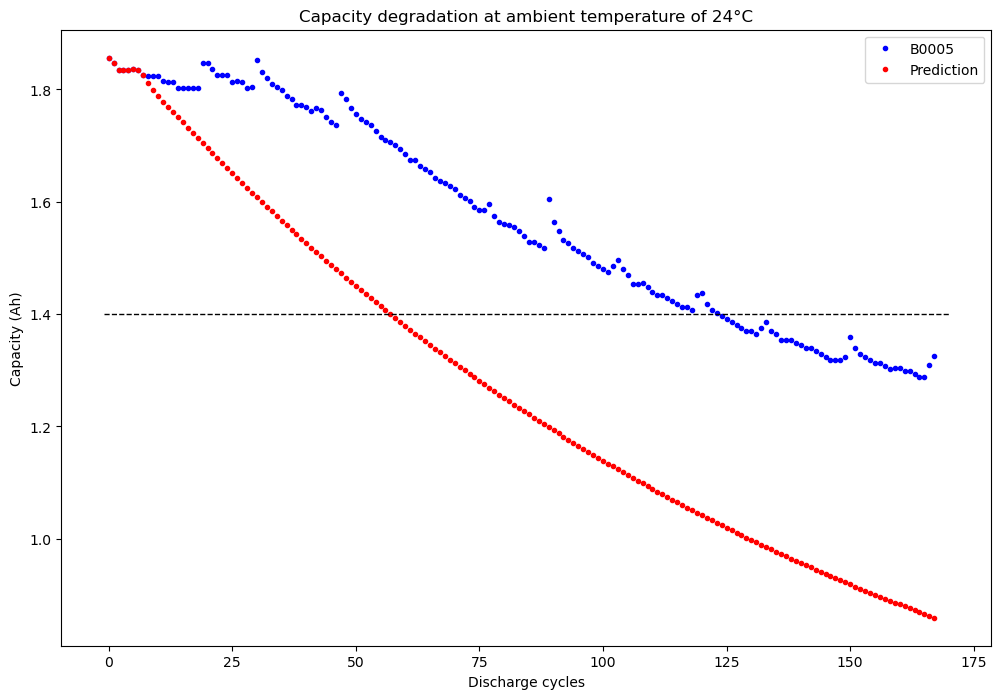

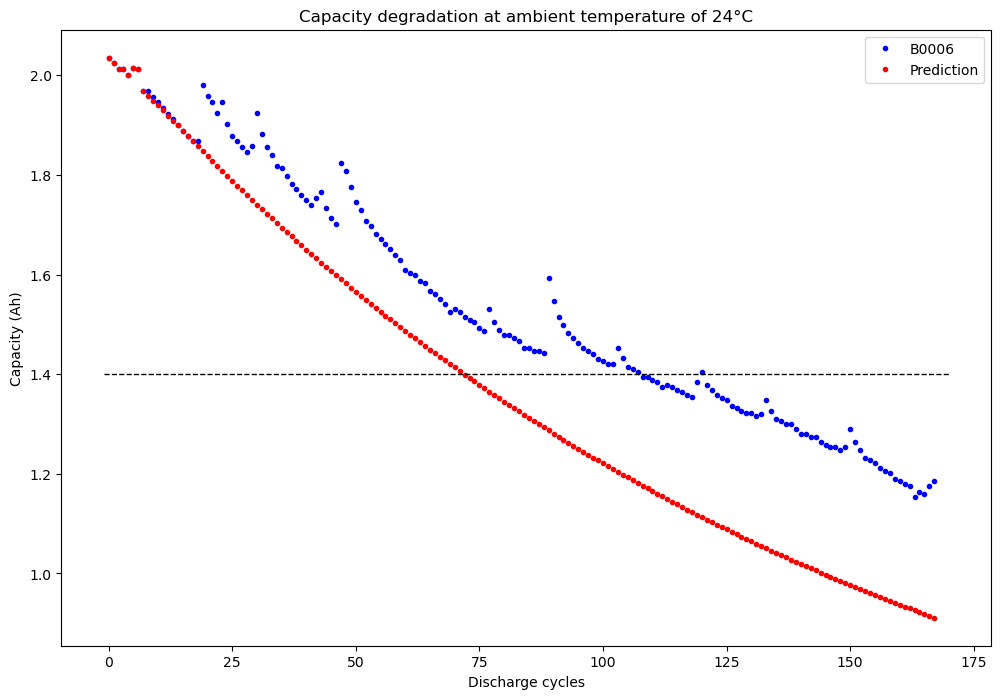

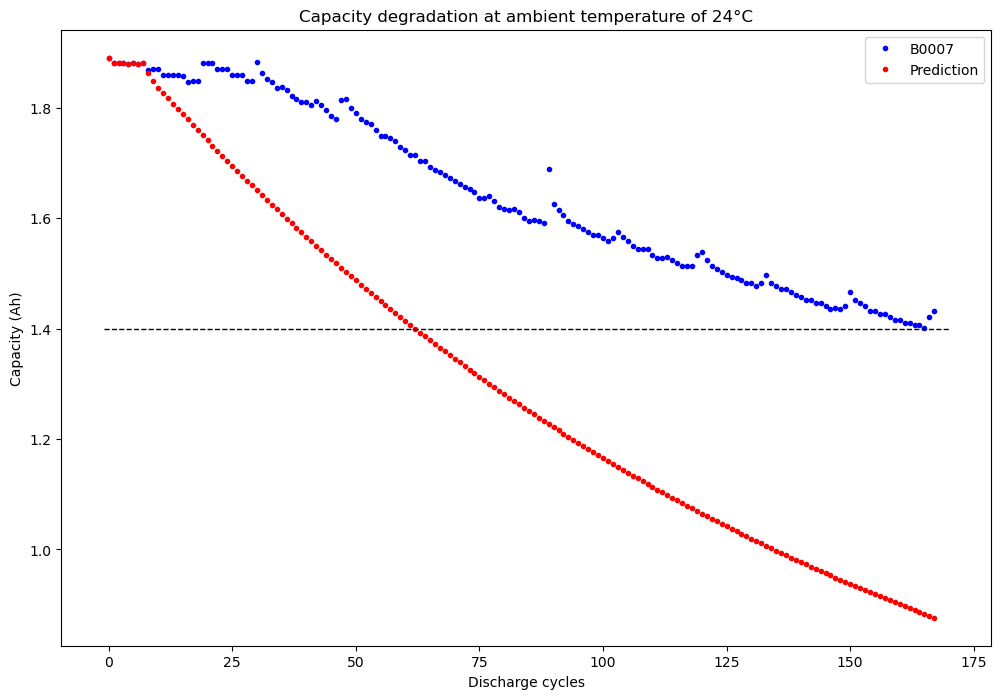

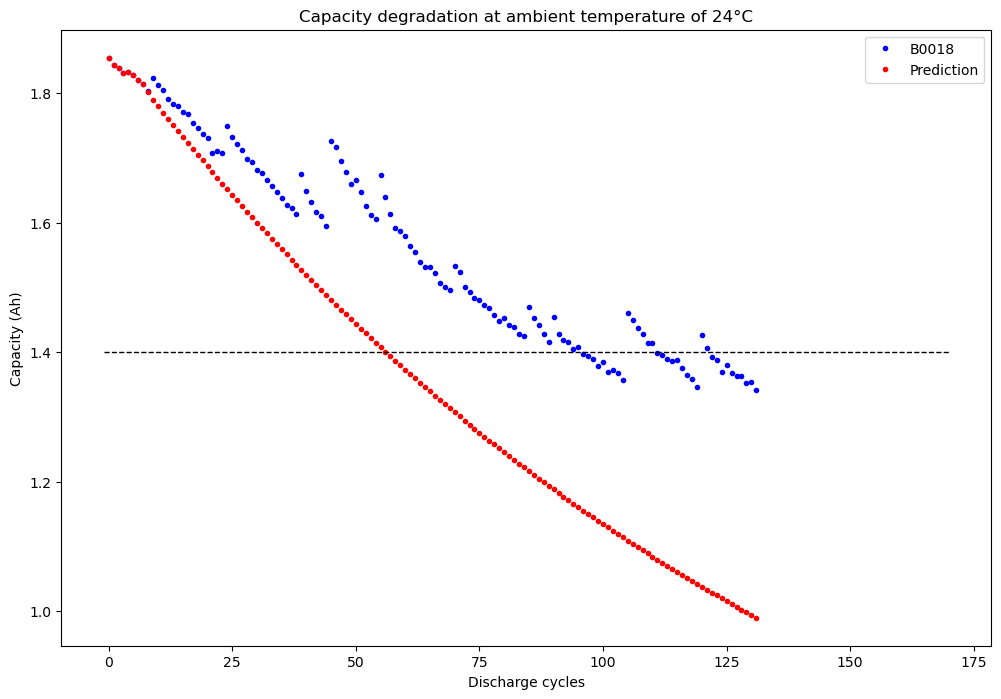

In [25]:
for name in data_dict.keys():
    train_x, train_y, train_data, test_data = get_train_test(data_dict, name, window_size)

    real = data_dict[name][1]
    prefix_x = data_dict[name][1][:window_size]
    decode_seq = model.decode(prefix_x,max_length=len(test_data))
    
    plot(name=name,
         real_data=real,
        pred_data=decode_seq)